In [9]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Burger' s equation
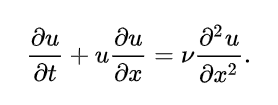
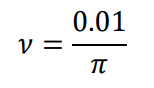
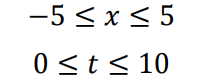
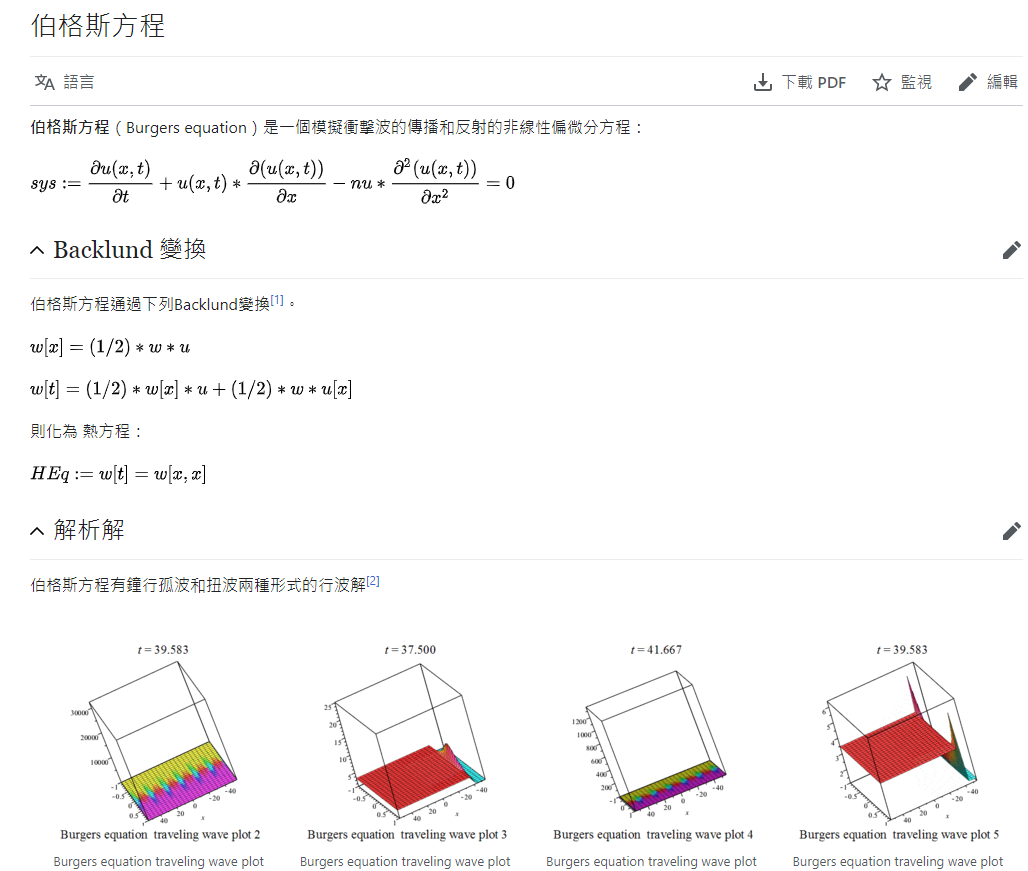

In [10]:
def pde(x, y):
    dy_x = tf.gradients(y, x)[0]
    dy_x, dy_t = dy_x[:, 0:1], dy_x[:,1:2]
    dy_xx = tf.gradients(dy_x, x)[0][:, 0:1]
    return (dy_t + y*dy_x - 0.01/np.pi * dy_xx)


In [11]:
geom = dde.geometry.Interval(-5, 5)
timedomain = dde.geometry.TimeDomain(0, 9.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)


In [12]:
#bc = 0
bc = dde.DirichletBC(geomtime, lambda x:0, lambda _, on_boundary: on_boundary)

#ic = -sin(pi*x)
ic = dde.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

In [13]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain = 30000,
    num_boundary = 1000,
    num_initial = 2000
)

Compiling model...
Building feed-forward neural network...
'build' took 0.052589 s

'compile' took 0.461981 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.38e-02, 3.99e-01, 5.36e-01]    [2.38e-02, 3.99e-01, 5.36e-01]    []  
1000      [1.15e-02, 3.50e-03, 3.63e-01]    [1.15e-02, 3.50e-03, 3.63e-01]    []  
2000      [3.71e-02, 1.61e-03, 1.98e-02]    [3.71e-02, 1.61e-03, 1.98e-02]    []  
3000      [2.74e-02, 2.92e-04, 5.94e-03]    [2.74e-02, 2.92e-04, 5.94e-03]    []  
4000      [2.62e-02, 1.21e-04, 4.77e-03]    [2.62e-02, 1.21e-04, 4.77e-03]    []  
5000      [2.55e-02, 7.25e-05, 4.35e-03]    [2.55e-02, 7.25e-05, 4.35e-03]    []  
6000      [2.51e-02, 9.94e-05, 4.04e-03]    [2.51e-02, 9.94e-05, 4.04e-03]    []  
7000      [2.46e-02, 3.87e-05, 3.93e-03]    [2.46e-02, 3.87e-05, 3.93e-03]    []  
8000      [2.41e-02, 3.36e-05, 3.79e-03]    [2.41e-02, 3.36e-05, 3.79e-03]    []  
9000   

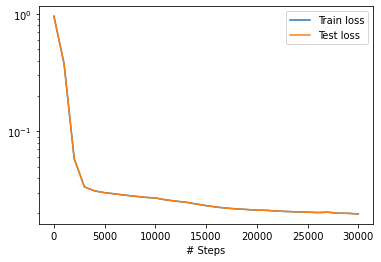

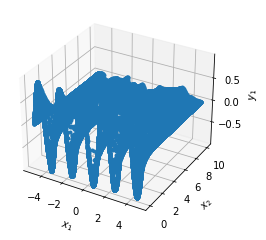

In [14]:
layers = [2] + [20]*3 +[1]

net = dde.maps.FNN(layers, "tanh", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr = 0.001)
losshistory, train_state = model.train(epochs = 30000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

In [15]:
x_data = np.linspace(-5, 5, num = 1000)
t_data = np.linspace(0, 10,num= 1000)
test_x, test_t = np.meshgrid(x_data, t_data)
test_domain = np.vstack((np.ravel(test_x), np.ravel(test_t))).T
predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain, operator = pde)
predicted_solution = predicted_solution.reshape(1000, 1000)
residual = residual.reshape(1000, 1000)

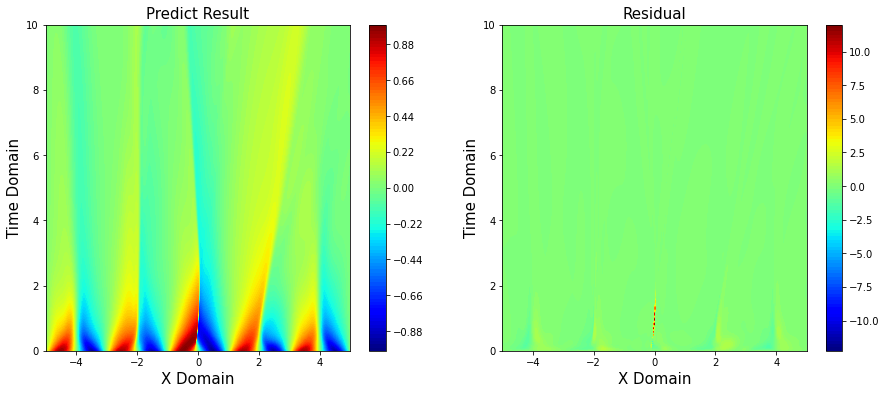

In [16]:
fig = plt.figure(figsize = (15, 6))
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Predict Result", fontsize = 15)
ax.set_xlabel("X Domain", fontsize = 15)
ax.set_ylabel("Time Domain", fontsize = 15)
cs = ax.contourf(x_data, t_data, predicted_solution, 100, cmap = "jet")
cbar = fig.colorbar(cs)


ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Residual", fontsize = 15)
ax2.set_xlabel("X Domain", fontsize = 15)
ax2.set_ylabel("Time Domain", fontsize = 15)
cs2 = ax2.contourf(x_data, t_data, residual, 100, cmap = "jet")
cbar2 = fig.colorbar(cs2)


plt.show()